In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%reload_ext lab_black

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_context("talk")
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.gridspec as gridspec

from src.load_data import load_data
from ZilongCode.utils import bandpassfilter, get_zero_phase

### Load example data

In [3]:
epoch_key = ("bon", 8, 4)

data = load_data(epoch_key)

Failed to load file: /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/Raw-Data/Bond/bonDIO08.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/Raw-Data/Bond/bonDIO08.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/Raw-Data/Bond/bonDIO08.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/Raw-Data/Bond/bonDIO08.mat
No DIO file found, inferring correct inbound/outbound from task rules


### load the decoder

In [4]:
datafolder = (
    "/home/zilong/Desktop/replay_trajectory_paper/Processed-Data/ThetaSweepTrajectories"
)

animal, day, epoch = epoch_key
# load the classifier results
cv_classifier_clusterless_results = xr.open_dataset(
    os.path.join(
        datafolder,
        f"{animal}_{day:02d}_{epoch:02d}_cv_classifier_clusterless_results.nc",
    )
)

# get all time slice
t = data["position_info"].index / np.timedelta64(1, "s")

### plot decoded theta sweeps in a selected time window

In [14]:
def plot_thetasweeps(time_slice, t, results, data, add_zero_phase_index=False):

    """
    Modified from https://github.com/edeno/replicate_kenny_analysis/blob/master/notebooks/Bond_day8_Epoch4.ipynb
    by Zilong, 30/08/2023
    plor the theta sweeps in time_slice
    Input:
        time_slice: the time slice to plot
        t: the time index
        results: the results from the model
        data: the data from the model
        add_zero_phase_index: whether to add the zero phase index
    Output:
        a plot with 3 subplots
    """

    cmap = plt.cm.inferno
    cmap.set_bad("white", alpha=1.0)
    labelsize = 10
    ticksize = 8
    # set background color to white
    sns.set_style("white")

    fig, axes = plt.subplots(
        3,
        1,
        figsize=(5, 2.5),
        sharex=True,
        constrained_layout=True,
        gridspec_kw={"height_ratios": [0.5, 3, 1]},
        dpi=300,
    )

    # ax 0: lfp from CA3
    ind = 0
    lfp = (
        data["lfps"]
        .reset_index(drop=True)
        .set_index(data["lfps"].index / np.timedelta64(1, "s"))
    )

    # plot as curve, not fill
    axes[0].plot(
        lfp.loc[time_slice].index.values,
        lfp.loc[time_slice].iloc[:, ind].values.squeeze(),
        color="grey",
        linewidth=1,
    )
    axes[0].set_ylabel("LFP")

    # add band passs filter to lfp.iloc[:,0], using band between 5-11Hz
    lfp0 = bandpassfilter(lfp.iloc[:, ind], lowcut=5, highcut=11, fs=500)
    # group the lfp0 into dataframe with time index
    lfp0 = pd.DataFrame(lfp0, index=lfp.index)

    # calculate the zero phase index
    zero_phase_index = get_zero_phase(lfp0[time_slice])

    # plot the filtered lfp
    axes[0].plot(
        lfp.loc[time_slice].index.values, lfp0[time_slice], color="black", linewidth=1
    )

    axes[0].scatter(
        lfp0[time_slice].index.values[zero_phase_index],
        lfp0[time_slice].values.squeeze()[zero_phase_index],
        color="red",
        s=2,
    )

    # ax 0 y ticks off
    axes[0].set_yticks([])

    # add title
    axes[0].set_title("Online sequences", fontsize=labelsize)

    # ax 1
    results["acausal_posterior"].sum("state", skipna=False).sel(time=time_slice).plot(
        x="time",
        y="position",
        robust=True,
        ax=axes[1],
        cmap=cmap,
        vmin=0.0,
    )

    arm_min_max = (
        data["position_info"]
        .groupby("arm_name")
        .linear_position.aggregate(["min", "max"])
    )
    max_time = results.sel(time=time_slice).time.max() + 0.01
    axes[1].text(
        max_time,
        arm_min_max.loc["Center Arm", "min"],
        "C",
        ha="left",
        va="bottom",
        weight="bold",
        fontsize=labelsize,
    )
    axes[1].text(
        max_time,
        arm_min_max.loc["Center Arm", "max"],
        "*",
        ha="left",
        va="top",
        weight="bold",
        fontsize=labelsize,
    )
    axes[1].text(
        max_time,
        arm_min_max.loc["Right Arm", "max"],
        "R",
        ha="left",
        va="top",
        weight="bold",
        fontsize=labelsize,
    )
    axes[1].text(
        max_time,
        arm_min_max.loc["Right Arm", "min"],
        "*",
        ha="left",
        va="center",
        weight="bold",
        fontsize=labelsize,
    )

    axes[1].text(
        max_time,
        arm_min_max.loc["Left Arm", "max"],
        "L",
        ha="left",
        va="top",
        weight="bold",
        fontsize=labelsize,
    )

    axes[1].text(
        max_time,
        arm_min_max.loc["Left Arm", "min"],
        "*",
        ha="left",
        va="center",
        weight="bold",
        fontsize=labelsize,
    )

    axes[1].set_ylabel("Position \n [cm]")

    axes[1].plot(
        data["position_info"].reset_index().set_index(t).loc[time_slice].index,
        data["position_info"]
        .reset_index()
        .set_index(t)
        .loc[time_slice]
        .linear_position,
        color="darkturquoise",
        linestyle="-",
        linewidth=1,
        alpha=1.0,
    )
    axes[1].set_xlabel("")

    # make the colorbar text smaller and label smaller
    cbar = axes[1].collections[0].colorbar
    cbar.ax.tick_params(labelsize=ticksize)
    cbar.ax.set_ylabel("Posterior Prob.", fontsize=labelsize, labelpad=15)

    if add_zero_phase_index:
        # add multiple vertical lines to indicate the zero phase
        for i in zero_phase_index:
            axes[0].axvline(
                x=lfp0[time_slice].index.values[i],
                color="grey",
                linestyle="--",
                linewidth=1,
                alpha=0.5,
            )

            axes[1].axvline(
                x=lfp0[time_slice].index.values[i],
                color="grey",
                linestyle="--",
                linewidth=1,
                alpha=0.5,
            )

    # ax 5
    axes[2].fill_between(
        data["position_info"].reset_index().set_index(t).loc[time_slice].index,
        data["position_info"]
        .reset_index()
        .set_index(t)
        .loc[time_slice]
        .speed.values.squeeze(),
        color="lightgrey",
        linewidth=1,
        alpha=0.9,
    )
    axes[2].set_ylabel("Speed \n [cm / s]")
    axes[2].set_xlabel("Time [s]")

    # add x ticks to the bottom plot only
    start_time = time_slice.start
    end_time = time_slice.stop
    axes[2].set_xticks(np.round(np.linspace(start_time, end_time, 4), 1))

    # algin the y labels of all subplots
    fig.align_ylabels(axes[:])

    # set the font size as 12 for all the subplots
    for ax in axes:
        ax.tick_params(labelsize=ticksize)
        ax.xaxis.label.set_size(labelsize)
        ax.yaxis.label.set_size(labelsize)
        # set axes off bottom left top and right
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

    # add back axes[2] bottom and left spines
    axes[2].spines["bottom"].set_visible(True)
    axes[2].spines["left"].set_visible(True)

    # save the figure to /home/zilong/Desktop/replay_trajectory_paper/Processed-Data/Paper_figures/
    savedir = (
        "/home/zilong/Desktop/replay_trajectory_paper/Processed-Data/Paper_figures/"
    )
    # start_time = time_slice.start
    # end_time = time_slice.stop
    # savename = "Fig1_theta_sweeps_" + str(start_time) + "_" + str(end_time) + ".png"
    savename = "Fig1_theta_sweeps.png"
    plt.savefig(savedir + savename, dpi=300, bbox_inches="tight")
    # also save pdf
    # plt.savefig(savedir + savename[:-4] + ".pdf", dpi=300, bbox_inches="tight")

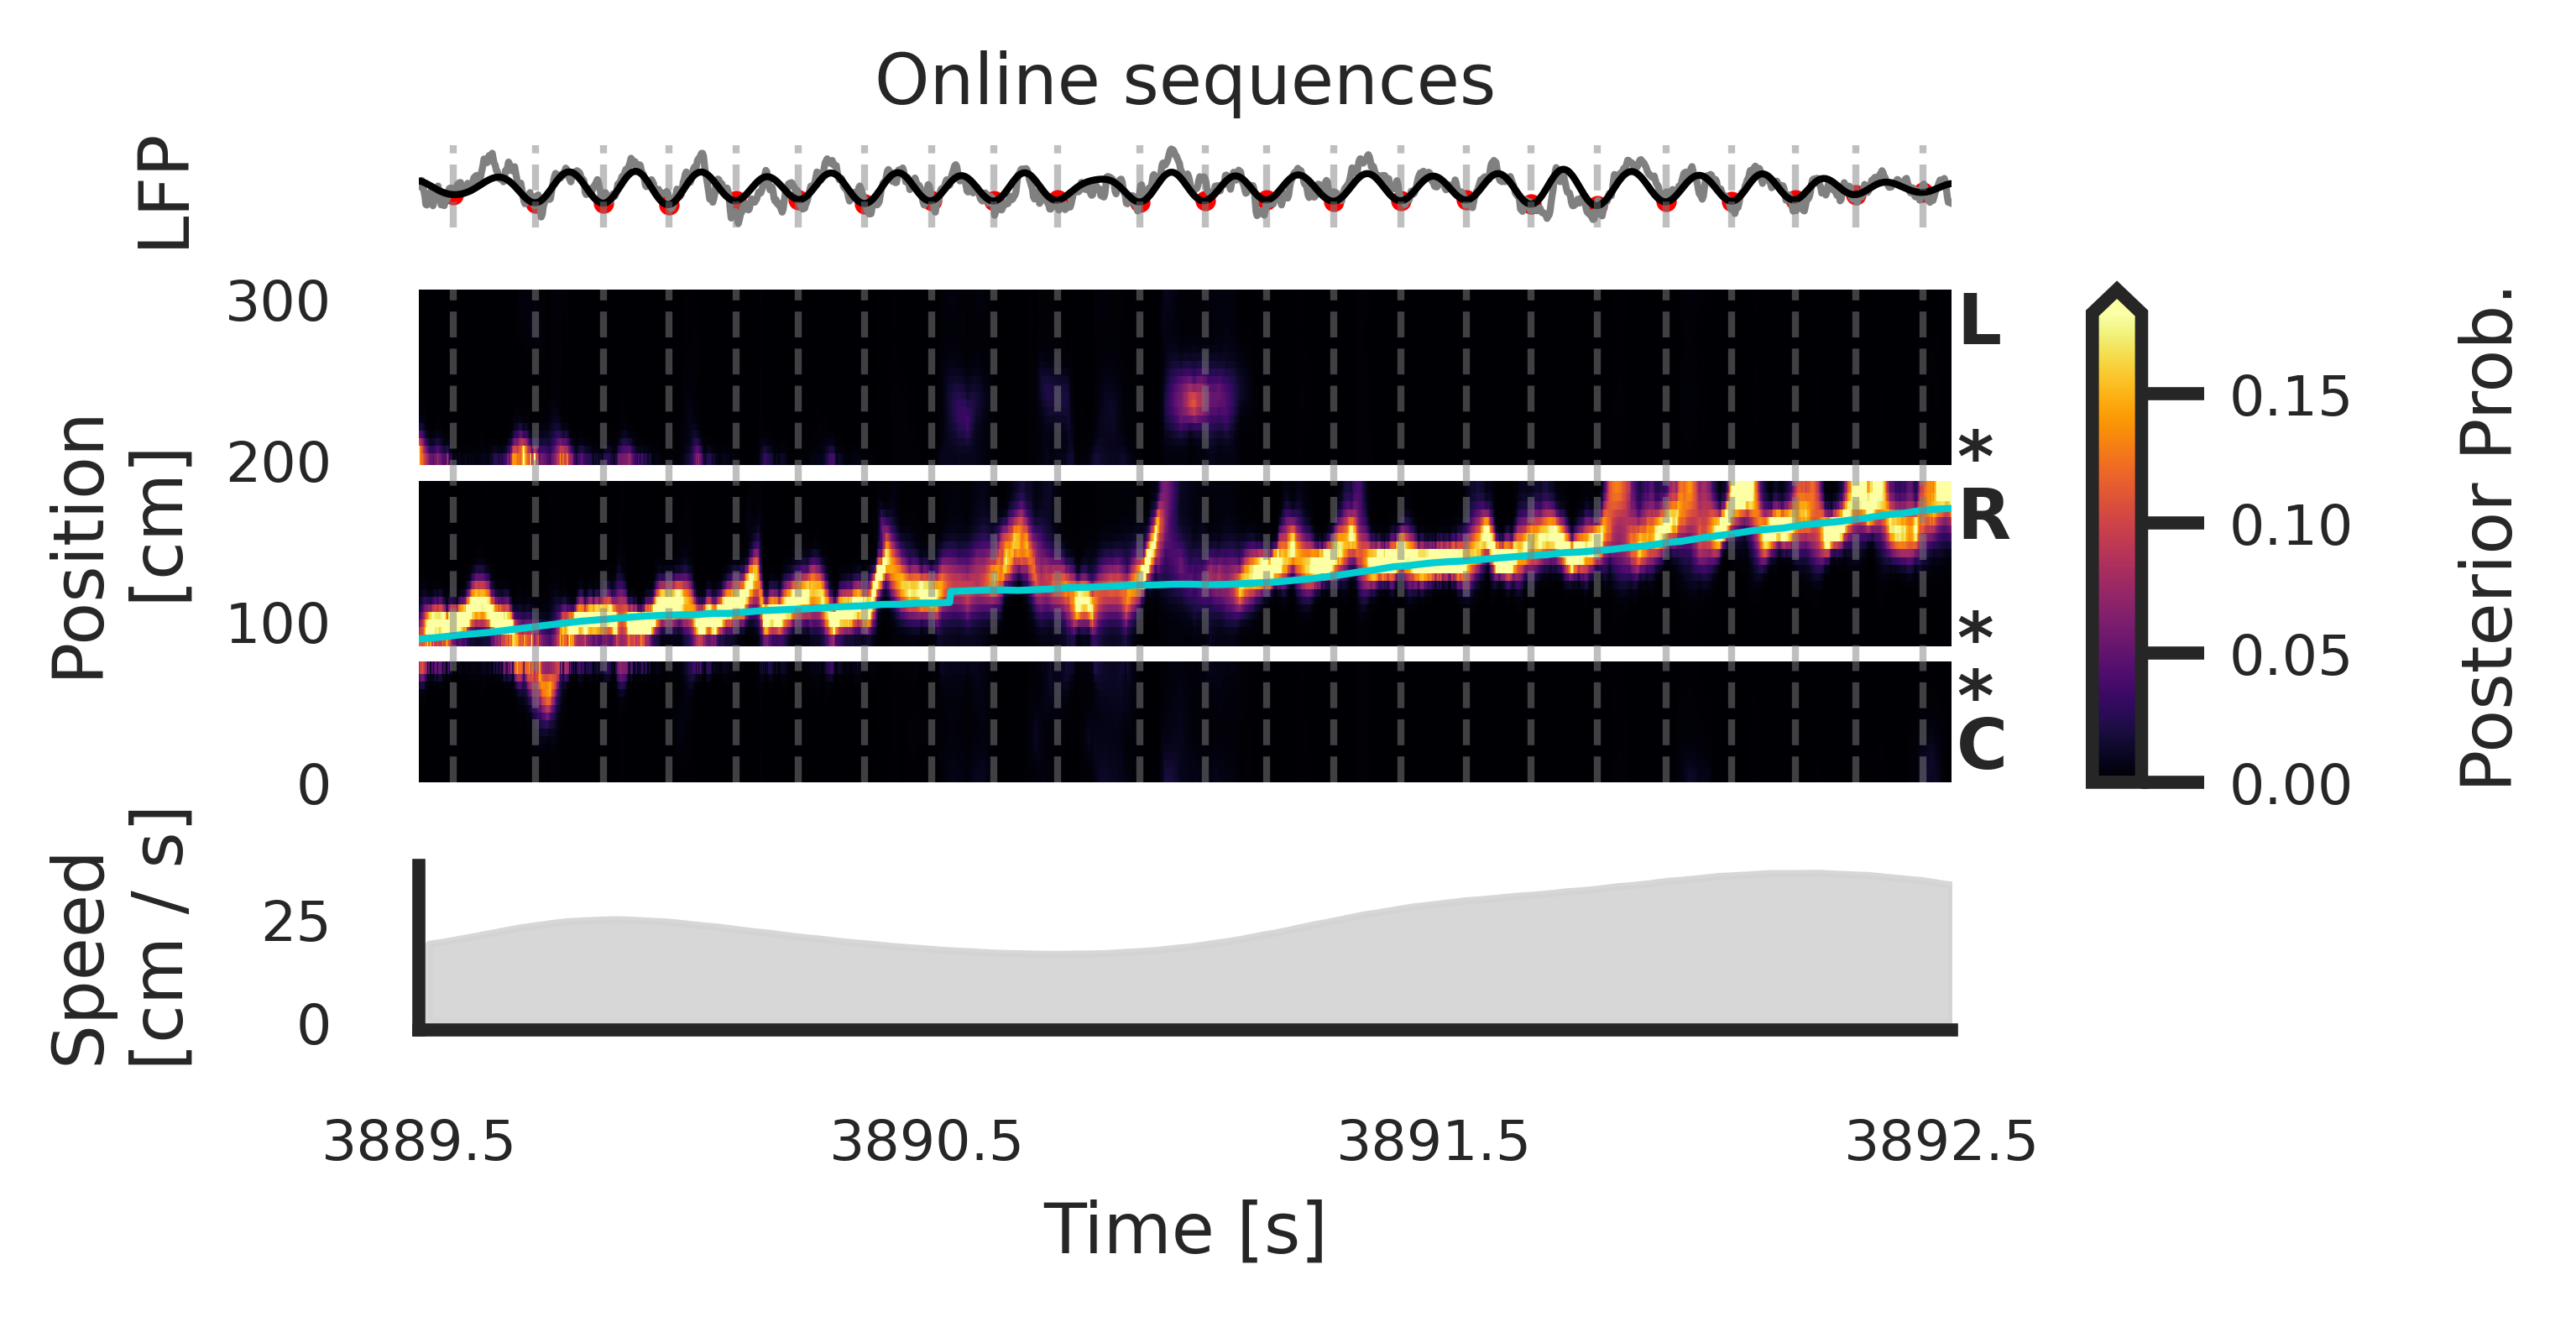

In [15]:
time_slice = slice(t.min() + 243.5, t.min() + 246.5)
plot_thetasweeps(
    time_slice, t, cv_classifier_clusterless_results, data, add_zero_phase_index=True
)

### plot decoded replay in a selected time window

In [16]:
def plot_awakereplay(time_slice, t, results, data):

    """
    Modified from https://github.com/edeno/replicate_kenny_analysis/blob/master/notebooks/Bond_day8_Epoch4.ipynb
    by Zilong, 30/08/2023
    plor the theta sweeps in time_slice
    Input:
        time_slice: the time slice to plot
        t: the time index
        results: the results from the model
        data: the data from the model
        add_zero_phase_index: whether to add the zero phase index
    Output:
        a plot with 3 subplots
    """

    cmap = plt.cm.inferno
    cmap.set_bad("white", alpha=1.0)
    labelsize = 10
    ticksize = 8
    # set background color to white
    sns.set_style("white")

    fig, axes = plt.subplots(
        3,
        1,
        figsize=(5, 2.5),
        sharex=True,
        constrained_layout=True,
        gridspec_kw={"height_ratios": [0.5, 3, 1]},
        dpi=300,
    )

    # ax 0: lfp from CA3
    ind = 0
    lfp = (
        data["lfps"]
        .reset_index(drop=True)
        .set_index(data["lfps"].index / np.timedelta64(1, "s"))
    )

    # plot as curve, not fill
    axes[0].plot(
        lfp.loc[time_slice].index.values,
        lfp.loc[time_slice].iloc[:, ind].values.squeeze(),
        color="grey",
        linewidth=1,
    )

    axes[0].set_ylabel("LFP")

    # ax 0 y ticks off
    axes[0].set_yticks([])

    # add title
    axes[0].set_title("Offline sequences", fontsize=labelsize)

    # ax 1
    results["acausal_posterior"].sum("state", skipna=False).sel(time=time_slice).plot(
        x="time",
        y="position",
        robust=True,
        ax=axes[1],
        cmap=cmap,
        vmin=0.0,
    )

    arm_min_max = (
        data["position_info"]
        .groupby("arm_name")
        .linear_position.aggregate(["min", "max"])
    )
    max_time = results.sel(time=time_slice).time.max() + 0.01
    axes[1].text(
        max_time,
        arm_min_max.loc["Center Arm", "min"],
        "C",
        ha="left",
        va="bottom",
        weight="bold",
        fontsize=labelsize,
    )
    axes[1].text(
        max_time,
        arm_min_max.loc["Center Arm", "max"],
        "*",
        ha="left",
        va="top",
        weight="bold",
        fontsize=labelsize,
    )
    axes[1].text(
        max_time,
        arm_min_max.loc["Right Arm", "max"],
        "R",
        ha="left",
        va="top",
        weight="bold",
        fontsize=labelsize,
    )
    axes[1].text(
        max_time,
        arm_min_max.loc["Right Arm", "min"],
        "*",
        ha="left",
        va="center",
        weight="bold",
        fontsize=labelsize,
    )

    axes[1].text(
        max_time,
        arm_min_max.loc["Left Arm", "max"],
        "L",
        ha="left",
        va="top",
        weight="bold",
        fontsize=labelsize,
    )

    axes[1].text(
        max_time,
        arm_min_max.loc["Left Arm", "min"],
        "*",
        ha="left",
        va="center",
        weight="bold",
        fontsize=labelsize,
    )

    axes[1].set_ylabel("Position \n [cm]")

    axes[1].plot(
        data["position_info"].reset_index().set_index(t).loc[time_slice].index,
        data["position_info"]
        .reset_index()
        .set_index(t)
        .loc[time_slice]
        .linear_position,
        color="darkturquoise",
        linestyle="-",
        linewidth=2,
        alpha=1.0,
    )
    axes[1].set_xlabel("")

    # make the colorbar text smaller and label smaller
    cbar = axes[1].collections[0].colorbar
    cbar.ax.tick_params(labelsize=ticksize)
    cbar.ax.set_ylabel("Posterior Prob.", fontsize=labelsize, labelpad=15)

    # add ripple times to the plot as red bars on top of the LFP
    # first get the ripples time within the time slice
    for i in data["ripple_times"].index:
        # get the ripple time
        ripple_time = data["ripple_times"].iloc[i - 1]
        start_time = ripple_time.loc["start_time"] / np.timedelta64(1, "s")
        end_time = ripple_time.loc["end_time"] / np.timedelta64(1, "s")
        # if start_time and end_time are both in the time slice. then add the ripple to the plot
        if start_time > time_slice.start and end_time < time_slice.stop:
            axes[0].axvspan(start_time, end_time, color="lightgrey", alpha=0.5, lw=0)
            axes[1].axvspan(start_time, end_time, color="lightgrey", alpha=0.5, lw=0)

    # ax 2
    axes[2].fill_between(
        data["position_info"].reset_index().set_index(t).loc[time_slice].index,
        data["position_info"]
        .reset_index()
        .set_index(t)
        .loc[time_slice]
        .speed.values.squeeze(),
        color="lightgrey",
        linewidth=1,
        alpha=0.9,
    )
    axes[2].set_ylabel("Speed \n [cm / s]")
    axes[2].set_xlabel("Time [s]")

    # add x ticks to the bottom plot only
    start_time = time_slice.start
    end_time = time_slice.stop
    axes[2].set_xticks(np.round(np.linspace(start_time, end_time, 4), 1))

    sns.despine()

    axes[2].set_ylim([0, 5])

    # algin the y labels of all subplots
    fig.align_ylabels(axes[:])

    # set the font size as 12 for all the subplots
    for ax in axes:
        ax.tick_params(labelsize=ticksize)
        ax.xaxis.label.set_size(labelsize)
        ax.yaxis.label.set_size(labelsize)
        # set axes off bottom left top and right
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

    # add back axes[2] bottom and left spines
    axes[2].spines["bottom"].set_visible(True)
    axes[2].spines["left"].set_visible(True)

    # save the figure to /home/zilong/Desktop/replay_trajectory_paper/Processed-Data/Paper_figures/
    savedir = (
        "/home/zilong/Desktop/replay_trajectory_paper/Processed-Data/Paper_figures/"
    )
    # start_time = time_slice.start
    # end_time = time_slice.stop
    savename = "Fig1_awakereplay.png"
    plt.savefig(savedir + savename, dpi=300, bbox_inches="tight")
    # also save pdf
    # plt.savefig(savedir + savename[:-4] + ".pdf", dpi=300, bbox_inches="tight")

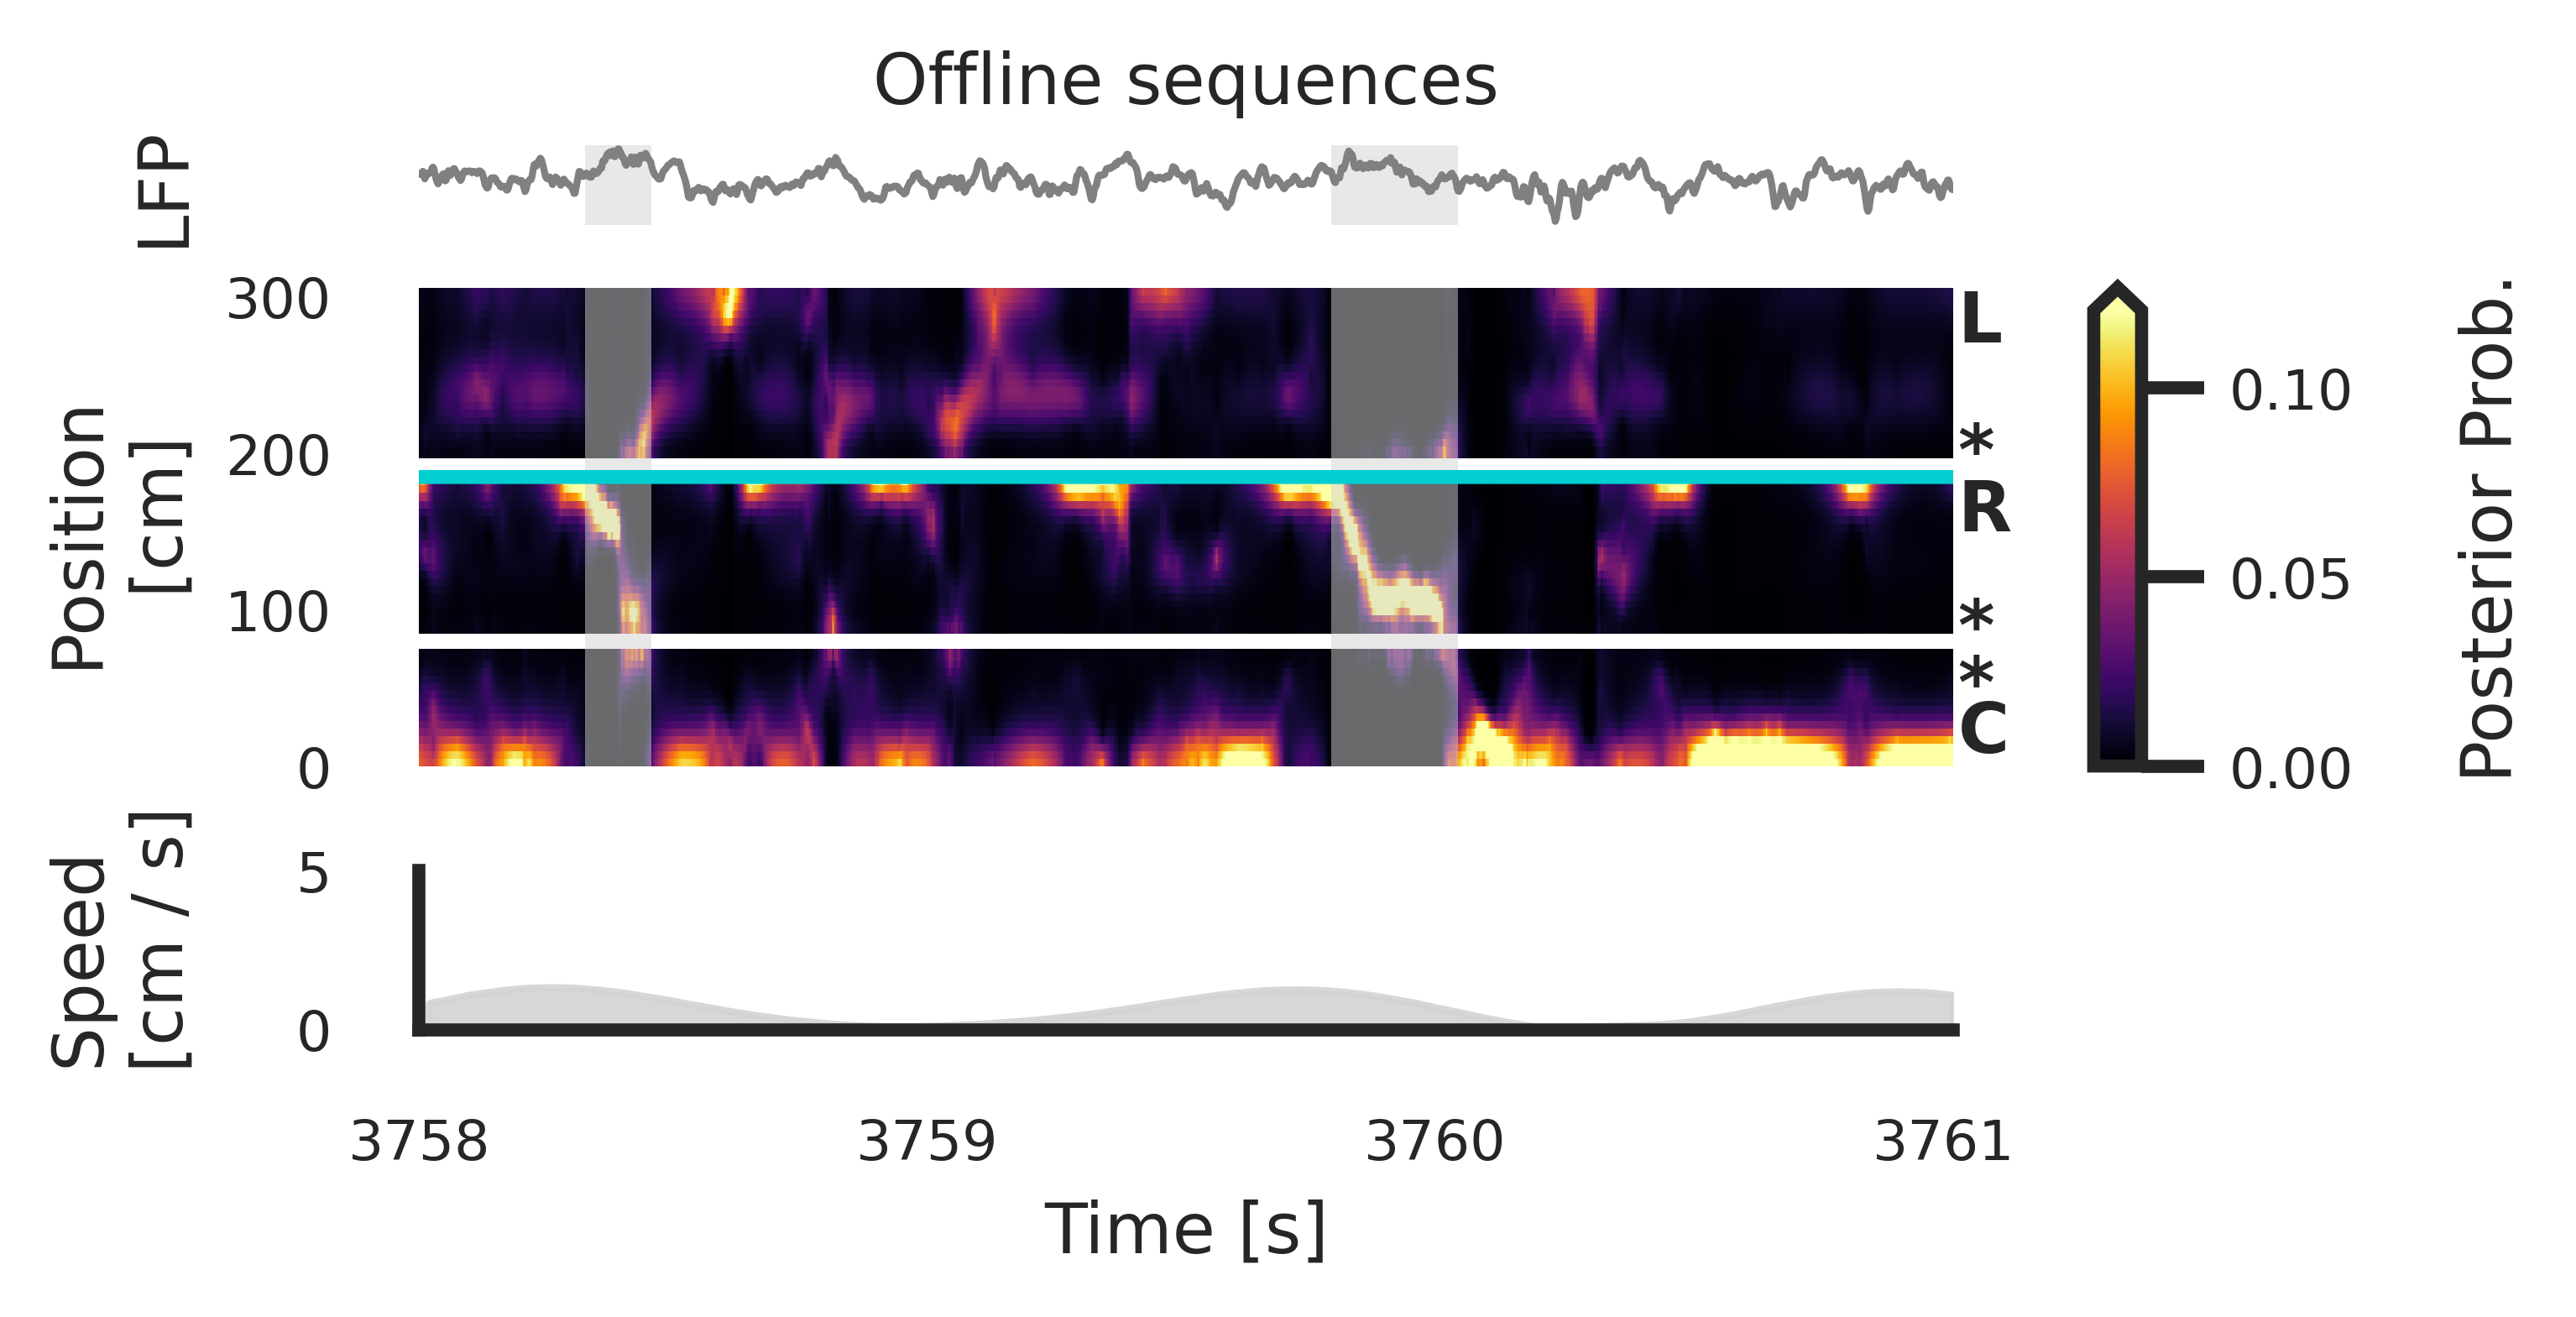

In [17]:
time_slice = slice(t.min() + 112, t.min() + 115)  # 107-117
plot_awakereplay(time_slice, t, cv_classifier_clusterless_results, data)

### select replay subtypes: stationary, Brownian motion, super-diffusion

In [8]:
def plot_replay_subtypes(
    time_slice, time_slice1, time_slice2, time_slice3, t, results, data
):

    """
    Modified from https://github.com/edeno/replicate_kenny_analysis/blob/master/notebooks/Bond_day8_Epoch4.ipynb
    by Zilong, 30/08/2023
    plor the theta sweeps in time_slice
    Input:
        time_slice: the time slice to plot
        t: the time index
        results: the results from the model
        data: the data from the model
        add_zero_phase_index: whether to add the zero phase index
    Output:
        a plot with 3 subplots
    """

    cmap = plt.cm.inferno
    cmap.set_bad("white", alpha=1.0)
    labelsize = 10
    ticksize = 8
    # set background color to white
    sns.set_style("white")

    # constrained_layout=True, dpi=300
    fig = plt.figure(figsize=(8.27, 3), constrained_layout=True, dpi=300)

    gs = gridspec.GridSpec(2, 3, height_ratios=[2, 1], width_ratios=[1, 1, 1])

    # ax 1
    ax1 = plt.subplot(gs[0, 0:3])
    results["acausal_posterior"].sum("state", skipna=False).sel(time=time_slice).plot(
        x="time",
        y="position",
        robust=True,
        ax=ax1,
        cmap=cmap,
        vmin=0.0,
    )

    arm_min_max = (
        data["position_info"]
        .groupby("arm_name")
        .linear_position.aggregate(["min", "max"])
    )
    max_time = results.sel(time=time_slice).time.max() + 0.01
    ax1.text(
        max_time,
        arm_min_max.loc["Center Arm", "min"],
        "C",
        ha="left",
        va="bottom",
        weight="bold",
        fontsize=labelsize,
    )
    ax1.text(
        max_time,
        arm_min_max.loc["Center Arm", "max"],
        "*",
        ha="left",
        va="top",
        weight="bold",
        fontsize=labelsize,
    )
    ax1.text(
        max_time,
        arm_min_max.loc["Right Arm", "max"],
        "R",
        ha="left",
        va="top",
        weight="bold",
        fontsize=labelsize,
    )
    ax1.text(
        max_time,
        arm_min_max.loc["Right Arm", "min"],
        "*",
        ha="left",
        va="center",
        weight="bold",
        fontsize=labelsize,
    )

    ax1.text(
        max_time,
        arm_min_max.loc["Left Arm", "max"],
        "L",
        ha="left",
        va="top",
        weight="bold",
        fontsize=labelsize,
    )

    ax1.text(
        max_time,
        arm_min_max.loc["Left Arm", "min"],
        "*",
        ha="left",
        va="center",
        weight="bold",
        fontsize=labelsize,
    )

    ax1.set_ylabel("Position \n [cm]")
    # plot without setting colorbars
    ax1.plot(
        data["position_info"].reset_index().set_index(t).loc[time_slice].index,
        data["position_info"]
        .reset_index()
        .set_index(t)
        .loc[time_slice]
        .linear_position,
        color="darkturquoise",
        linestyle="-",
        linewidth=2,
        alpha=1.0,
    )

    # add ripple times to the plot as red bars on top of the LFP
    # first get the ripples time within the time slice
    for i in data["ripple_times"].index:
        # get the ripple time
        ripple_time = data["ripple_times"].iloc[i - 1]
        start_time = ripple_time.loc["start_time"] / np.timedelta64(1, "s")
        end_time = ripple_time.loc["end_time"] / np.timedelta64(1, "s")
        # if start_time and end_time are both in the time slice. then add the ripple to the plot
        if start_time > time_slice.start and end_time < time_slice.stop:
            ax1.axvspan(start_time, end_time, color="lightgrey", alpha=0.5, lw=0)
        # if start_time and end_time are both in time_slice1, time_slice2, time_slice3.
        # then add the ripple to the plot as red bars
        if start_time > time_slice1.start and end_time < time_slice1.stop:
            ax1.axvspan(start_time, end_time, color="green", alpha=0.5, lw=0)
        if start_time > time_slice2.start and end_time < time_slice2.stop:
            ax1.axvspan(start_time, end_time, color="green", alpha=0.5, lw=0)
        if start_time > time_slice3.start and end_time < time_slice3.stop:
            ax1.axvspan(start_time, end_time, color="green", alpha=0.5, lw=0)

    # add x ticks to the bottom plot only, show 4-6 ticks (keep int part)
    ticks = np.linspace(time_slice.start, time_slice.stop, 4, dtype=int)
    # add 's' to the ticks
    ax1.set_xticks(ticks)
    # set the xticklabels as the time in seconds
    ticklabels = [str(i) + "s" for i in ticks]
    ax1.set_xticklabels(ticklabels)

    # ax1.set_xlabel("Time [s]")
    # set xlabel off
    ax1.set_xlabel("")

    # set the font size as 12 for all the subplots
    ax1.tick_params(labelsize=ticksize)
    ax1.xaxis.label.set_size(labelsize)
    ax1.yaxis.label.set_size(labelsize)

    # set axis invisible
    ax1.spines["right"].set_visible(False)
    ax1.spines["top"].set_visible(False)
    ax1.spines["left"].set_visible(False)
    ax1.spines["bottom"].set_visible(False)

    # remove coorbar and space it consumes
    ax1.collections[0].colorbar.remove()

    ax2 = plt.subplot(gs[1, 0])
    ax3 = plt.subplot(gs[1, 1])
    ax4 = plt.subplot(gs[1, 2])

    axs = [ax2, ax3, ax4]
    time_slices = [time_slice1, time_slice2, time_slice3]
    titles = ["Superdiffusion", "Stationary", "Diffusion"]

    # zip ax and time slice together
    for axi, time_slicei, titlei in zip(axs, time_slices, titles):

        # plot
        results["acausal_posterior"].sum("state", skipna=False).sel(
            time=time_slicei
        ).plot(
            x="time",
            y="position",
            robust=True,
            ax=axi,
            cmap=cmap,
            vmin=0.0,
        )
        # remove all labels, ticks and spines in axi, as well as colorbars
        axi.set_xlabel("")
        axi.set_ylabel("")
        axi.set_xticks([])
        axi.set_yticks([])
        axi.spines["right"].set_visible(False)
        axi.spines["top"].set_visible(False)
        axi.spines["left"].set_visible(False)
        axi.spines["bottom"].set_visible(False)
        axi.collections[0].colorbar.remove()
        # add title
        axi.set_title(titlei, fontsize=labelsize)

        # add a scale bar marking 0.1s under the plot, please do not overlap with the plot
        axi.plot(
            [time_slicei.start + 0.0, time_slicei.start + 0.1],
            [-50, -50],
            color="black",
            linewidth=3,
        )
        # add text below the scale bar as '100 ms'
        axi.text(
            time_slicei.start + 0.05,
            -200,
            "100 ms",
            ha="center",
            va="bottom",
            fontsize=ticksize,
        )

        # set y ticks as [-100,300] but without showing the ticks
        axi.set_yticks([-100, 300])
        axi.set_yticklabels([])

        # add ripple times to the plot as red bars on top of the LFP
        # first get the ripples time within the time slice
        for i in data["ripple_times"].index:
            # get the ripple time
            ripple_time = data["ripple_times"].iloc[i - 1]
            start_time = ripple_time.loc["start_time"] / np.timedelta64(1, "s")
            end_time = ripple_time.loc["end_time"] / np.timedelta64(1, "s")
            # if start_time and end_time are both in the time slice. then add the ripple to the plot
            # x range is start_time to end_time, y range is [0,300]
            if start_time > time_slicei.start and end_time < time_slicei.stop:
                axi.axvspan(
                    start_time,
                    end_time,
                    ymin=0.25,
                    ymax=1,
                    color="lightgrey",
                    alpha=0.5,
                    lw=0,
                )

    # tight layout
    plt.tight_layout()
    # reduce the gap between first row and second row
    gs.update(hspace=0.7)

    # save the figure to /home/zilong/Desktop/replay_trajectory_paper/Processed-Data/Paper_figures/
    savedir = (
        "/home/zilong/Desktop/replay_trajectory_paper/Processed-Data/Paper_figures/"
    )
    # start_time = time_slice.start
    # end_time = time_slice.stop
    savename = "Fig1_awakereplay_subtypes.png"
    plt.savefig(savedir + savename, dpi=300, bbox_inches="tight")
    # also save pdf
    # plt.savefig(savedir + savename[:-4] + ".pdf", dpi=300, bbox_inches="tight")

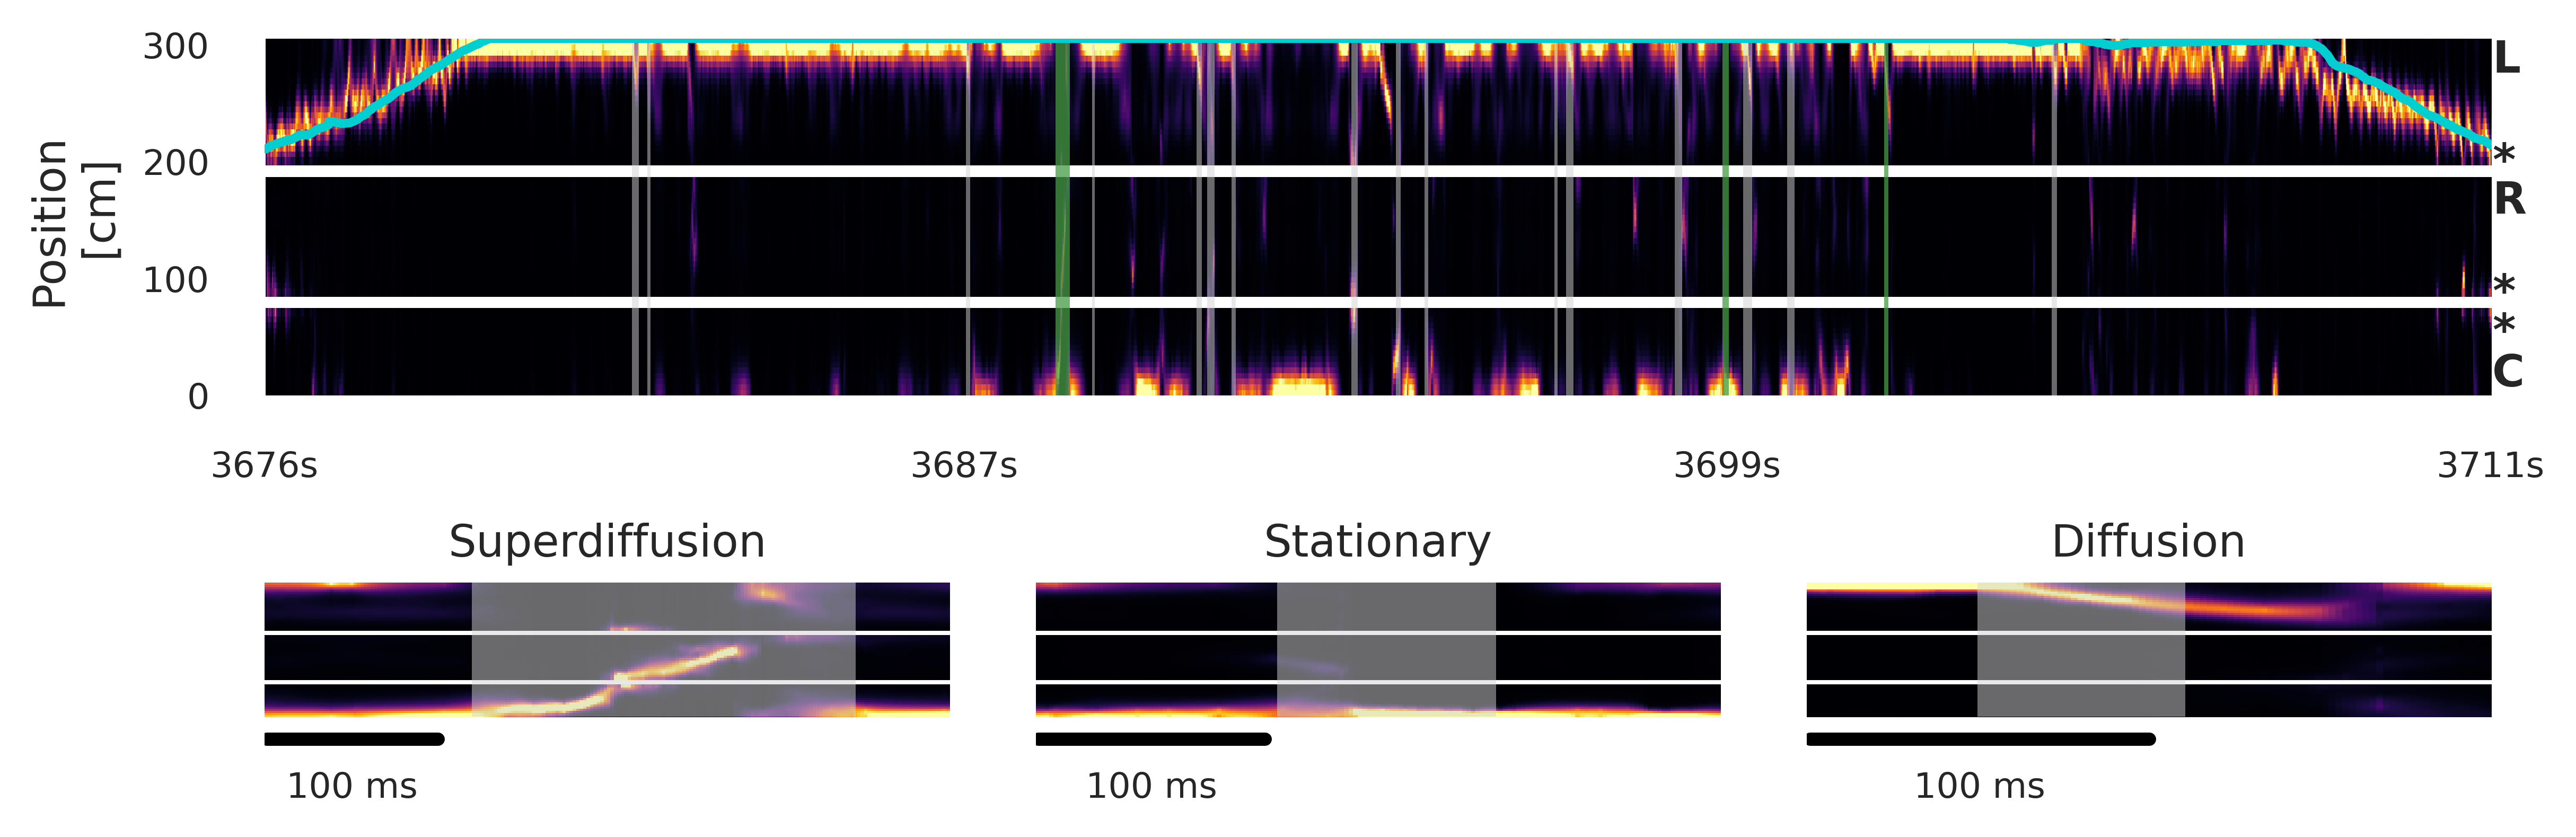

In [9]:
time_slice_all = slice(t.min() + 30, t.min() + 65)
time_slice1 = slice(t.min() + 42.3, t.min() + 42.7)
time_slice2 = slice(t.min() + 52.8, t.min() + 53.1)
time_slice3 = slice(t.min() + 55.4, t.min() + 55.6)

plot_replay_subtypes(
    time_slice_all,
    time_slice1,
    time_slice2,
    time_slice3,
    t,
    cv_classifier_clusterless_results,
    data,
)